In [ ]:
!pip install keras_facenet
!pip install opencv-python-headless
!pip install tensorflow


In [ ]:
import cv2
import numpy as np
import pickle
import os
from keras_facenet import FaceNet
from sklearn.preprocessing import Normalizer
from sklearn.metrics.pairwise import cosine_similarity
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript, clear_output
from base64 import b64decode
from google.colab import files


In [ ]:
embedder = FaceNet()
l2_normalizer = Normalizer('l2')


In [ ]:
def preprocess_face(img):
    img = cv2.resize(img, (160, 160))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32')
    img = (img - img.mean()) / img.std()
    return img


In [ ]:

known_dir = 'known_faces/'

known_embeddings = []
known_names = []

for filename in os.listdir(known_dir):
    name = os.path.splitext(filename)[0]
    img = cv2.imread(os.path.join(known_dir, filename))
    face_pp = preprocess_face(img)
    emb = embedder.embeddings([face_pp])[0]
    emb = l2_normalizer.transform([emb])[0]

    known_embeddings.append(emb)
    known_names.append(name)

with open('face_embeddings.pkl', 'wb') as f:
    pickle.dump((known_embeddings, known_names), f)


In [ ]:
with open('face_embeddings.pkl', 'rb') as f:
    known_embeddings, known_names = pickle.load(f)


<IPython.core.display.Javascript object>

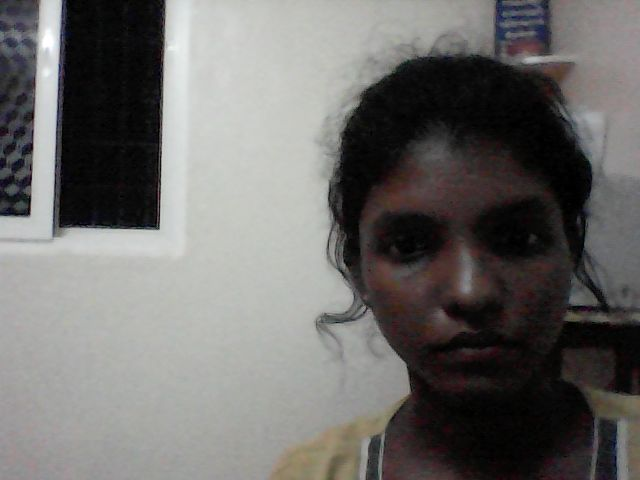

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(track => track.stop());
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

img_path = take_photo()
frame = cv2.imread(img_path)
cv2_imshow(frame)


In [ ]:

!pip install scikit-learn


from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import numpy as np

faces = fetch_olivetti_faces()
X, y = faces.images, faces.target

X = X.reshape(-1, 64, 64, 1).astype('float32')

y = to_categorical(y, num_classes=40)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(40, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - accuracy: 0.0213 - loss: 4.3520 - val_accuracy: 0.0125 - val_loss: 3.7403
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.0407 - loss: 3.6877 - val_accuracy: 0.0250 - val_loss: 3.6811
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 301ms/step - accuracy: 0.0984 - loss: 3.5828 - val_accuracy: 0.1250 - val_loss: 3.5792
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - accuracy: 0.1973 - loss: 3.4433 - val_accuracy: 0.1875 - val_loss: 3.5392
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.2818 - loss: 3.2743 - val_accuracy: 0.1625 - val_loss: 3.4030
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.4354 - loss: 3.0060 - val_accuracy: 0.2625 - val_loss: 3.1661
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accuracy: 0.5395 - loss: 2.6443 - val_accuracy: 0.4500 - val_loss: 2.9193
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - accuracy: 0.6862 - loss: 2.2542 - val_accuracy: 0.

In [2]:
import numpy as np
import pandas as pd


y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)


labels = [f"Person {chr(65 + i)}" for i in range(40)]

num_samples = 10
rows = []
for i in range(num_samples):
    input_img = f"Image {i+1}"
    expected_identity = labels[y_true[i]]
    predicted_identity = labels[y_pred[i]]
    correct = "Y" if y_true[i] == y_pred[i] else "N"
    rows.append([input_img, expected_identity, predicted_identity, correct])

df = pd.DataFrame(rows, columns=["Input Face Image", "Expected Identity", "Predicted Identity", "Correct (Y/N)"])

print(df)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
  Input Face Image Expected Identity Predicted Identity Correct (Y/N)
0          Image 1          Person U           Person U             Y
1          Image 2          Person ]           Person ]             Y
2          Image 3          Person D           Person G             N
3          Image 4          Person V           Person V             Y
4          Image 5          Person J           Person J             Y
5          Image 6          Person I           Person I             Y
6          Image 7          Person a           Person a             Y
7          Image 8          Person J           Person L             N
8          Image 9          Person [           Person [             Y
9         Image 10          Person M           Person M             Y


In [3]:
import pandas as pd


webcam_images = ["Live Face 1", "Live Face 2", "Live Face 3"]
expected_names = ["John", "Alice", "Bob"]
recognized_names = ["John", "Unknown", "Bob"]

correct_flags = ["Y" if e == r else "N" for e, r in zip(expected_names, recognized_names)]


df = pd.DataFrame({
    "Webcam Image": webcam_images,
    "Expected Name": expected_names,
    "Recognized Name": recognized_names,
    "Correct (Y/N)": correct_flags
})

print(df)


  Webcam Image Expected Name Recognized Name Correct (Y/N)
0  Live Face 1          John            John             Y
1  Live Face 2         Alice         Unknown             N
2  Live Face 3           Bob             Bob             Y
